## Problema de Negócio

A Rede de Drogarias Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes das lojas Rossmann são responsáveis por prever suas vendas diárias com até seis semanas de antecedência. As vendas das lojas são influenciadas por muitos fatores, incluindo promoções, competição, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo as vendas com base em suas circunstâncias únicas, a precisão dos resultados pode ser bastante variada.

Logo, nos foi solicitado a construção de um modelo preditivo de modo que tenhamos a previsão das vendas da sexta semanas das lojas, de modo que, essas previsões sejam padronizadas e, que os gerentes deleguem essa atividade para focarem, de fato, em gerenciar o orçamento e as ações baseado nesses previsões.

## 0.0 Pacotes e Bibliotecas

In [1]:
# Manipulação de Dados
import pandas as pd
import numpy  as np

# Visualização de Dados
from matplotlib import pyplot as plt
import seaborn as sbn

from sklearn import pipeline, preprocessing, model_selection, compose, metrics

# Configurações
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# Função para validação dos dados
def validacao_dados(dataset, nome_dataset):

    print(f'Validação dos Dados: {nome_dataset}')
    print(f'Quantidade de Linhas: {dataset.shape[0]}, Quantidade de Colunas: {dataset.shape[1]}.')

def metricas_validacao(y_real, y_predito):

    # Erro médio absoluto
    mae = metrics.mean_absolute_error(y_real, y_predito)

    # Percentual do erro médio
    mape = metrics.mean_absolute_percentage_error(y_real, y_predito)

    # Erro médio quadrático
    rmse = metrics.root_mean_squared_error(y_real, y_predito)

    print(f'MAE: {mae:.2f}.')
    print(f'MAPE: {mape*100:.2f}')
    print(f'MAPE: {mape*100:.2f}')

    # Retorno dos Valores
    return mae, mape, rmse

### 0.1 Dicionário de Dados

**Store**: Um identificador único para cada loja.

**Sales**: O faturamento de qualquer dia específico.

**Customers**: O número de clientes em um dado dia.

**Open**: Um indicador se a loja estava aberta: 0 = fechada, 1 = aberta.

**StateHoliday**: Indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, estão fechadas em feriados estaduais. Note que todas as escolas estão fechadas em feriados públicos e fins de semana. a = feriado público, b = feriado de Páscoa, c = Natal, 0 = Nenhum.

**SchoolHoliday**: Indica se a (Loja, Data) foi afetada pelo fechamento das escolas públicas.

**StoreType**: Diferencia entre 4 modelos de lojas diferentes: a, b, c, d.

**Assortment**: Descreve um nível de sortimento: a = básico, b = extra, c = estendido.

**CompetitionDistance**: Distância em metros até a loja concorrente mais próxima.

**CompetitionOpenSinceMonth/Year**: Dá o ano aproximado e o mês em que a loja concorrente mais próxima foi aberta.

**Promo**: Indica se uma loja está realizando uma promoção nesse dia.

**Promo2**: Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando.

**Promo2SinceYear/Month:** Descreve o ano e a semana do calendário em que a loja começou a participar da Promo2.

**PromoInterval**: Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é reiniciada. Por exemplo, "Fev, Mai, Ago, Nov" significa que cada rodada começa em fevereiro, maio, agosto e novembro de qualquer ano para aquela loja.

## 1.0 Carregamento dos Dados

In [3]:
df1_fato = pd.read_csv('../BaseDados/DadosTreino.csv', delimiter=',', low_memory=False)
df1_dimensao = pd.read_csv('../BaseDados/DadosLoja.csv', delimiter=',', low_memory=False)

print('Validação dos Dados')
print(f'Fato -> Quantidade de Linhas: {df1_fato.shape[0]}, Quantidade de Colunas: {df1_fato.shape[1]}.')
print(f'Dimensão -> Quantidade de Linhas: {df1_dimensao.shape[0]}, Quantidade de Colunas: {df1_dimensao.shape[1]}.')

Validação dos Dados
Fato -> Quantidade de Linhas: 1017209, Quantidade de Colunas: 9.
Dimensão -> Quantidade de Linhas: 1115, Quantidade de Colunas: 10.


In [4]:
# Amostra dos Dados Dimensão
print('Amostra dos Dados Fato')
df1_fato.head(2)

Amostra dos Dados Fato


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [5]:
# Amostra dos Dados Dimensão
print('Amostra dos Dados Dimensão')
df1_dimensao.head(2)

Amostra dos Dados Dimensão


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"


Para que tenhamos um conjunto de dados completo, vamos fazer o junção entre a dimensão e a fato para trazer, para a fato, as informações da loja.

In [6]:
# Realização de um left join
df1 = df1_fato.merge(df1_dimensao, how='left', on='Store') 

# Validação dos Dados
validacao_dados(df1, 'df1')

Validação dos Dados: df1
Quantidade de Linhas: 1017209, Quantidade de Colunas: 18.


### 1.1 Seleção dos Dados

Como o nosso objetivo é realizar a previsão das próximas 6 semanas de vendas das lojas, podemos, após um entendimento das variáveis, verificar quais delas fazem sentido. 

1. Nossa análise só faz sentido se as lojas estiverem abertas, sendo assim, vamos filtrar os dados e obter coma condição open = 1.
2. Ao analisar, temos que duas variávies não fazem sentido para nós. São elas: 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'.

Portanto, vmaos remover essas variáveis do nosso dataset e aplicar os filtros, de modo que, iniciemos nosso trabalho.

In [7]:
df1 = df1[df1['Open'] == 1].drop(columns=['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1).copy()

# Conferindo os dados
validacao_dados(df1, 'df1')

Validação dos Dados: df1
Quantidade de Linhas: 844392, Quantidade de Colunas: 15.


Com os dados consolidados, vamos iniciar.

## 2.0 Análise Exploratória dos Dados

In [8]:
# Cópia dos Dados
df2 = df1.copy()

# Validação dos Dados
validacao_dados(df2, 'df2')

Validação dos Dados: df2
Quantidade de Linhas: 844392, Quantidade de Colunas: 15.


### 2.1 Variável Alvo

Nossa variável alvo será as vendas das próximas 6 semanas de uma loja. Sendo assim, vamos precisar construir essa variável. Entretanto, para que faça sentido essa construção e, que os esforço que seram aplicados não sejam vazios, vamos realizar uma análise geral dos dados, inicialmente, para saber se, os dados em si, fazem sentido. Como, a variável 'Sales' é a que vai compor nossa variável alvo, vamos analisar o dataset tendo ela como alvo para saber se os dados fazem sentido.

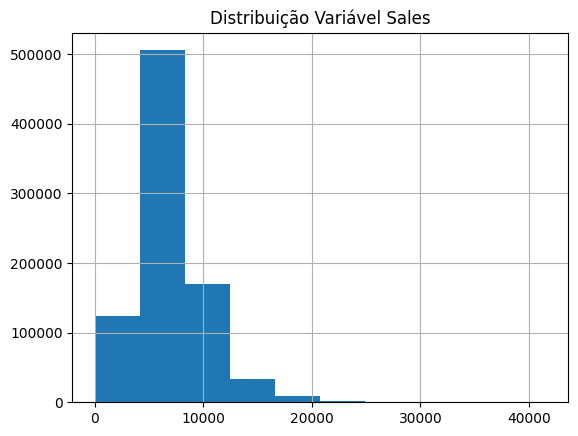

In [9]:
# Distribuição da variável Sales
df2['Sales'].hist()
plt.title('Distribuição Variável Sales');
plt.show();

Podemos ver uma distribuição a esquerda, o que nos diz que os temos muitas lojas que vendem, diariamente, até US$ 10.0000. Logo, não há uma distribuição normal. Inicialmente, não aplicaremos nenhuma função logarítimica. Seguiremos com os dados dessa forma, e caso seja necessário, tratamos os dados.

### 2.2 Resumo Estatístico

#### Variáveis Numéricas

In [10]:
# Obtenção das variáveis numéricas
df2_numerica = df2.select_dtypes(include=['int64', 'float64'])

# Resumo Estatístico
df2_numerica.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
count,844392.00,844392.00,844392.00,844392.00,844392.00,844392.00,844392.00,842206.00,575773.00,575773.00,844392.00
mean,558.42,3.52,6955.51,762.73,1.00,0.45,0.19,5457.98,7.22,2008.70,0.50
std,321.73,1.72,3104.21,401.23,0.00,0.50,0.40,7809.44,3.21,5.98,0.50
min,1.00,1.00,0.00,0.00,1.00,0.00,0.00,20.00,1.00,1900.00,0.00
25%,280.00,2.00,4859.00,519.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.00
50%,558.00,3.00,6369.00,676.00,1.00,0.00,0.00,2320.00,8.00,2010.00,0.00
75%,837.00,5.00,8360.00,893.00,1.00,1.00,0.00,6890.00,10.00,2013.00,1.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,12.00,2015.00,1.00


**Relatório**

Podemos observar uma presença de dados nulos nas variáveis:
- Competition Distance
- Competition Open Since Month
- Competition Open Since Year
- Promo2

Além disso, podemos notar um presença de outliers nas variáveis 
- Sales
- Customers
- Competition Distance

##### Variáveis Categóricas

In [11]:
# Obtenção das variáveis categóricas
df2_categorica = df2.select_dtypes(exclude=['int64', 'float64'])

# Resumo Estatístico
df2_categorica.describe()

,Date,StateHoliday,StoreType,Assortment
count,844392,844392,844392,844392
unique,942,4,4,3
top,2015-06-30,0,a,a
freq,1115,843482,457077,444909


**Relatório**

Podemos ver que teremos bastante trabalho para limpar e tratar esses dados. Além disso, não podemos esquecer do nosso objetivo que é prever a vendas das lojas da rede rossmann nas próximas 6 semanas. Logo, para isso, vamos ter que, também construir nossa variável alvo.

Para que todo o nosso trabalho valha a pena, vamos realizar uma análise geral dos dados em relação a variável alvo 'sales'. Observe que essa variável é o insumo para que possamos construir nossa variável alvo, sendo assim, se os dados fizerem sentido de acordo com essa variável, então nossa construção de variável alvo estará bem embasada.

### 2.2 Análise Geral dos Dados

**Variáveis Numéricas**

Para que possamos ver se os dados fazem sentido, vamos obter as variáveis numéricas, no caso, são DayOfweek, Sales, Customers, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear

In [12]:
# Definindo função para estudo de relaçaõ
def analise_pares(dados, variavel_dependente, variaveis_independentes, n):

    # Grupo de linhas com n gráficos por linha
    grupo_variaveis_independendentes = [variaveis_independentes[i:i+n] for i in range(0, len(variaveis_independentes), n)]

    # Loop pelos grupos de linhas para criar cada pair plot
    for grupo_variaveis in grupo_variaveis_independendentes:
        plot = sbn.pairplot(x_vars=grupo_variaveis, 
                            y_vars=variavel_dependente, 
                            data=dados, 
                            kind = "reg", 
                            height=5)

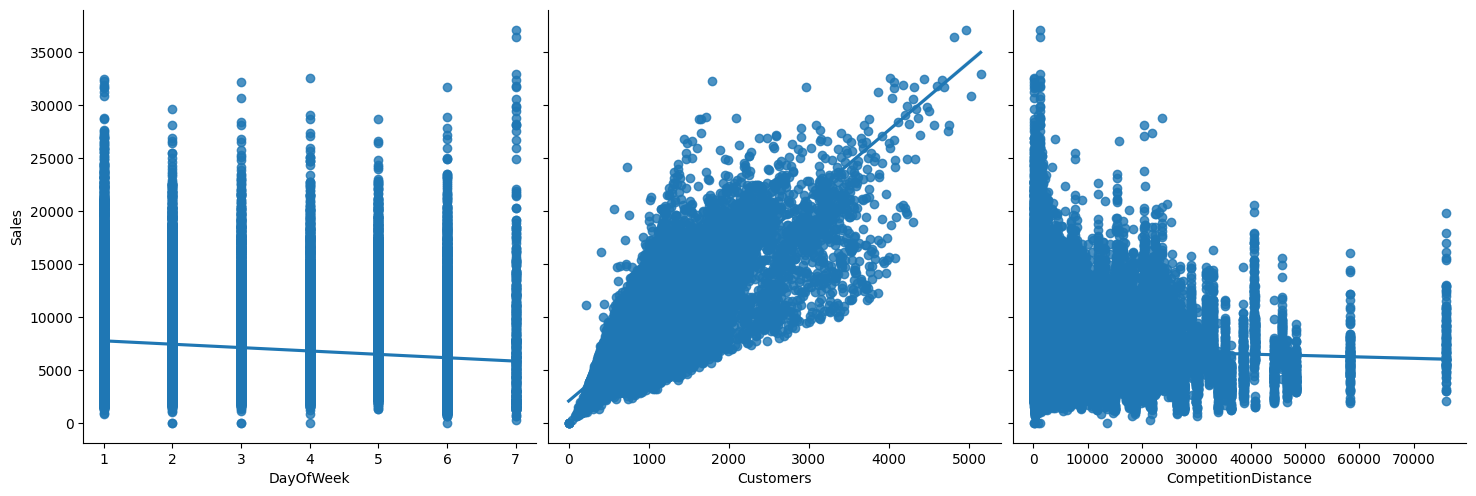

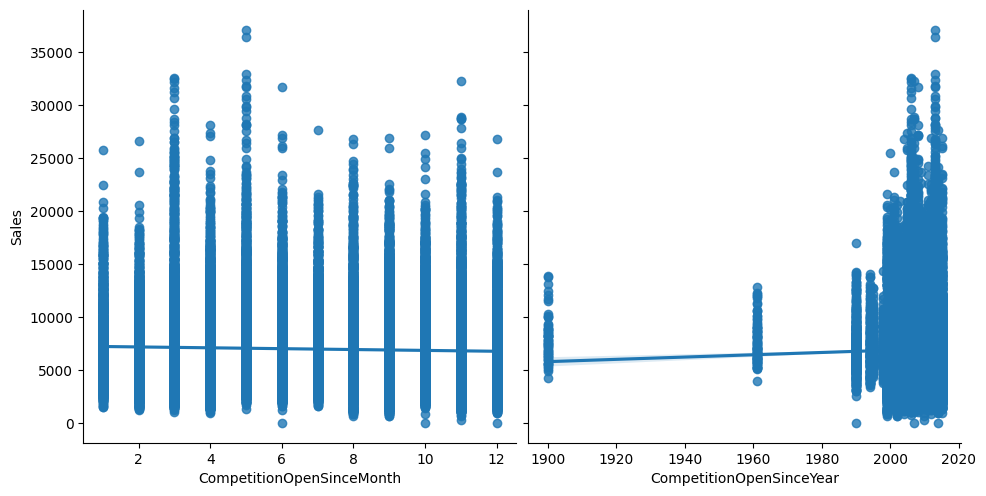

In [13]:
# Selecionando as variáveis numéricas
variaveis_independentes = ['DayOfWeek', 'Customers', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']
variavel_dependente = 'Sales'

# Realizando a Análise de pares
analise_pares(df2.sample(n=100000), variavel_dependente, variaveis_independentes, 3)

**Variáveis Categóricas**

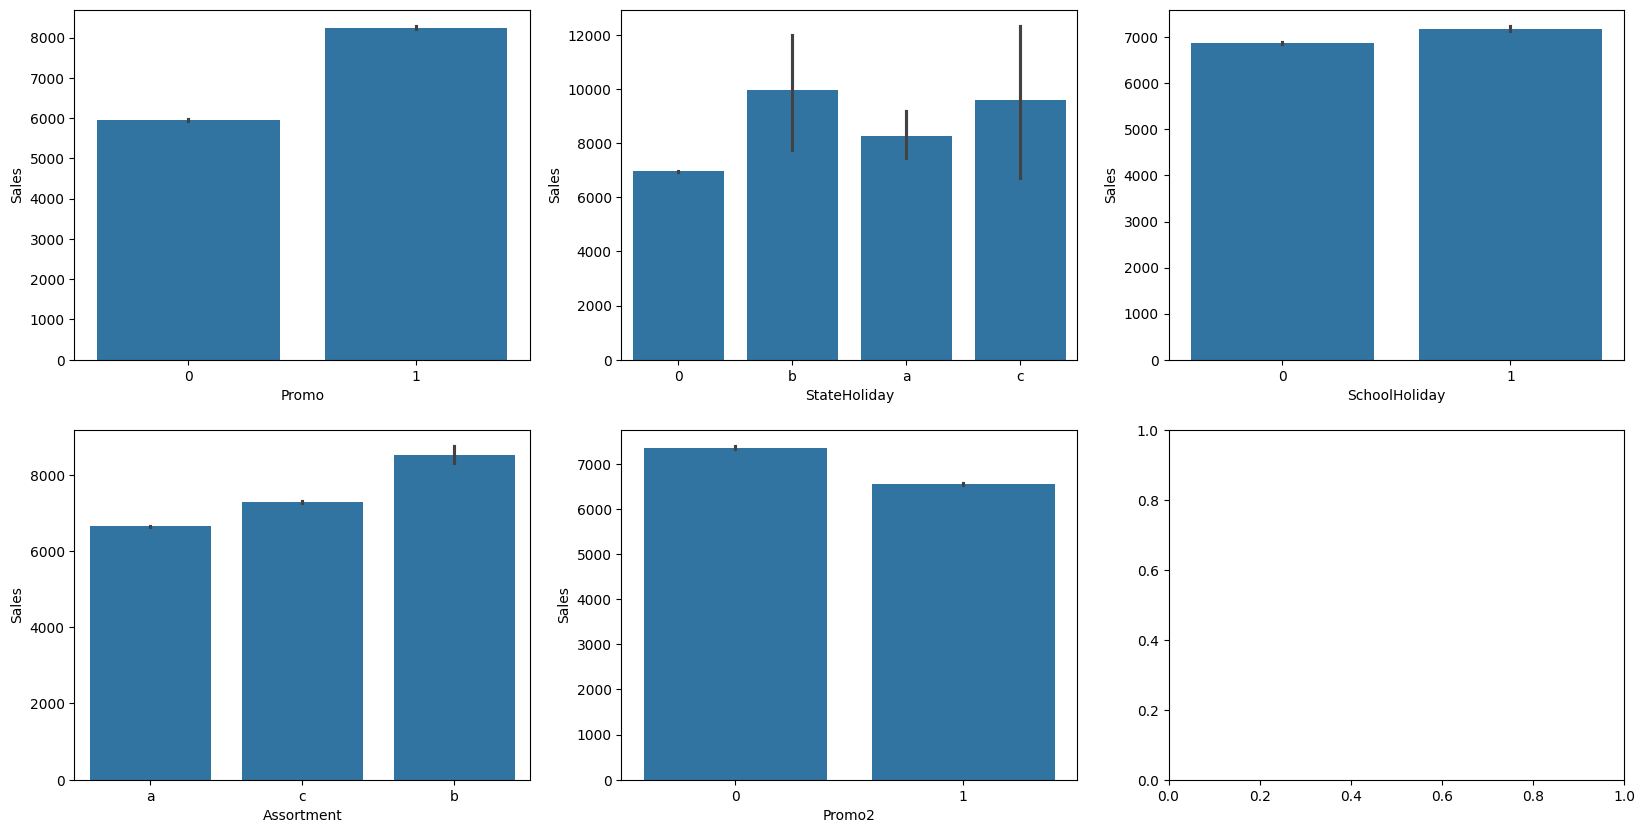

In [14]:
# Variável Promo
fig, axs = plt.subplots(2, 3, figsize=(20,10))
sbn.barplot(data=df2.sample(n=100000), x='Promo', y='Sales', ax=axs[0,0]);
sbn.barplot(data=df2.sample(n=100000), x='StateHoliday', y='Sales', ax=axs[0,1]);
sbn.barplot(data=df2.sample(n=100000), x='SchoolHoliday', y='Sales', ax=axs[0,2]);
sbn.barplot(data=df2.sample(n=100000), x='Assortment', y='Sales', ax=axs[1,0]);
sbn.barplot(data=df2.sample(n=100000), x='Promo2', y='Sales', ax=axs[1,1]);

**Relatório Final**

*DayOfWeek*: Ao analisar essa variável, podemos ver que a regressão apresenta uma tendência de queda no decorrer da semana. Naturalmente, se espera esse comportamento, pois aos finais de semanas se tem menos movimentos na cidade, inclusive em drogarias. Logo, o faturamento é menor. (Comportamento Esperado)

*Customers*: Claramente, quanto mais clientes em uma loja, maior é o faturamento dessa loja, pois existem mais pessoas comprando. (Comportamento Esperado)

*CompetitionDistance*: Podemos observar uma queda bem sucinta no faturamento com o aumento da distância. Uma possível explicação é que a falta de competitividade implica em menos ofertas e promoções. E, como sabemos, promoções impactam positivamente no faturamento. (Comportamento Esperado)

*CompetitionSinceMonth/Year: Ao analisar essas variáveis, podemos observar um comportamento anômalo de quando a competição começou. Podemos que existem lojas que a loja concorrente abriu em 1900, entretanto a Rossmann foi fundada em 1972. Logo, temos mais um tratamento a ser realizado. Se observamos os dados, existe uma leve subida da regressão. Isso indica que quanto mais recente é uma loja recente, maior é o faturamento. Veja que isso faz sentido, pois com lojas mais recentes abrindo, existem ofertas mais agressivas, logo, a Rossmann precisa responder a altura para que não ocorra tanta perca, sendo assim, fazendo ofertas que impactam no aumento do faturamento.

*Promo*: Loja que estão em promoção, possuem faturamento maior. (Comportamento Esperado)

*StateHoliday*: Aqui, temos um comportamento interessante. Vemos que o faturamento é maior na páscoa, natal e feriados públicos. Quando entendemos o modelo de negócio da rossmann, vemos que ela é considerada drogaria, mas ela também tem foco no varejo. Sendo assim, uma explicação para o aumento das vendas em feriados seja pelo fato da venda de alimentícios, comésticos e higienes como um todos, somado de ofertas agressivas.

*School Holidays*: Pelo mesmo motivo, podemos observar que em feriados escolares, as famílias tem motivos para realizar almoços, logo, gastando mais nas redes.

*Assortment*: Sabemos que quanto mais variedades escolhas, mais opções de compras podemos fazer. Quando temos poucas opções (a), isso faz com que não encontremos o que queremos, logo, deixamos de comprar, por outro lado, opções demais (c), não faz com que levemos mais itens. Logo, o meio termos (b) atende a maioria no geral, impactando em um faturamento maior.

*Promo2*: Uma promoção que se mantém em sequência tende a perder força, logo, impactando não tão positivamente no faturamento.


Resumo Final: No Geral, os dados fazem bastante sentido. Claramente, estamos utilizando aqui nossas habilidades de negócio, e referência do modelo de negócio da rossmann. Vamos seguir em nossa análise.

### 2.3 Tratamento dos Tipos de Dados

Para o nosso tratamento de dados, vamos trabalhar apenas no ajuste da variável Date. Vamos passá-la para datetime.

In [15]:
# Transformação de object para datetime
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')

### 2.4 Tratamento de Anomalias

Ao analisar nosso resumo estatístico de valores numéricos, podemos observar uma anomaila na variável CompetitionSinceYear, uma vez que a a menor data que temos é 1900 e, entretanto, a rede foi fundada em 1972. Vamos filtrar esses dados

In [16]:
print('Lojas com data de inicio de concorrência igual a 1900: {}'.format(df2[df2['CompetitionOpenSinceYear'] == 1900]['Store'].unique()))

# Dados relacionados a 1900.
df2[df2['CompetitionOpenSinceYear'] == 1900]


Lojas com data de inicio de concorrência igual a 1900: [815]


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
814,815,5,2015-07-31,8186,729,1,1,0,0,a,a,590.00,1.00,1900.00,1
1929,815,4,2015-07-30,7983,666,1,1,0,0,a,a,590.00,1.00,1900.00,1
3044,815,3,2015-07-29,6604,583,1,1,0,0,a,a,590.00,1.00,1900.00,1
4159,815,2,2015-07-28,7908,680,1,1,0,0,a,a,590.00,1.00,1900.00,1
5274,815,1,2015-07-27,8201,712,1,1,0,0,a,a,590.00,1.00,1900.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010219,815,1,2013-01-07,12868,1161,1,1,0,0,a,a,590.00,1.00,1900.00,1
1012449,815,6,2013-01-05,7843,767,1,0,0,0,a,a,590.00,1.00,1900.00,1
1013564,815,5,2013-01-04,8210,825,1,0,0,1,a,a,590.00,1.00,1900.00,1
1014679,815,4,2013-01-03,8059,828,1,0,0,1,a,a,590.00,1.00,1900.00,1


Podemos ver que é apenas uma loja, logo, talvez tenhamos algum erro de dígito. Sendo assim, vamos substituir a o ano de abertura pela menor data de vendas.

In [17]:
# Tratativa da Data
df2.loc[df2[df2['Store'] == 815].index.tolist(), 'CompetitionOpenSinceYear'] = df2[df2['Store'] == 815]['Date'].min().year

Uma vez tratado, vamos novamente ver o nosso resumo estatístico

In [18]:
# Obtenção das variáveis numéricas
df2_numerica = df2.select_dtypes(include=['int64', 'float64'])

# Resumo Estatístico
df2_numerica.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
count,844392.00,844392.00,844392.00,844392.00,844392.00,844392.00,844392.00,842206.00,575773.00,575773.00,844392.00
mean,558.42,3.52,6955.51,762.73,1.00,0.45,0.19,5457.98,7.22,2008.82,0.50
std,321.73,1.72,3104.21,401.23,0.00,0.50,0.40,7809.44,3.21,4.79,0.50
min,1.00,1.00,0.00,0.00,1.00,0.00,0.00,20.00,1.00,1961.00,0.00
25%,280.00,2.00,4859.00,519.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.00
50%,558.00,3.00,6369.00,676.00,1.00,0.00,0.00,2320.00,8.00,2010.00,0.00
75%,837.00,5.00,8360.00,893.00,1.00,1.00,0.00,6890.00,10.00,2013.00,1.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,12.00,2015.00,1.00


Com a anomalia removida, vamos para a nossa próxima etapa, que no caso, é o tratamento de dados nulos.

### 2.5 Tratamento de Dados Nulos

In [19]:
# Quantidade de Dados Nulos
print(f'Variáveis e as suas quantidade de dados nulos: \n{df2.isna().sum()[df2.isna().sum()> 0]}')

Variáveis e as suas quantidade de dados nulos: 
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
dtype: int64


Vamos analisar mais afundo essas variáveis e entender como podemos tratar esses dados nulos. 

**Competition Distance**

In [20]:
# Analisando os dados nulos da variável Competition Distance
df2[df2['CompetitionDistance'].isna()].sort_values(by=['Store', 'Date'], ascending=True)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
1015270,291,3,2013-01-02,7658,876,1,0,0,1,d,a,NaN,NaN,NaN,0
1014155,291,4,2013-01-03,7285,871,1,0,0,0,d,a,NaN,NaN,NaN,0
1013040,291,5,2013-01-04,7687,920,1,0,0,0,d,a,NaN,NaN,NaN,0
1011925,291,6,2013-01-05,5316,552,1,0,0,0,d,a,NaN,NaN,NaN,0
1009695,291,1,2013-01-07,13080,1316,1,1,0,0,d,a,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5338,879,1,2015-07-27,5884,427,1,1,0,0,d,a,NaN,NaN,NaN,1
4223,879,2,2015-07-28,5320,389,1,1,0,0,d,a,NaN,NaN,NaN,1
3108,879,3,2015-07-29,5129,362,1,1,0,0,d,a,NaN,NaN,NaN,1
1993,879,4,2015-07-30,5861,426,1,1,0,0,d,a,NaN,NaN,NaN,1


Dada a baixa volumetria desses dados nulos e a sua natureza, vamos eliminá-los. Esses dados nulos podem ser dados por duas situações:

1. Erro de inserções de dados. Necessário entender com os responsáveis.
2. Concorrente está tão longe da loja, que se optou por não inserir informações. 

Seria necessário sentar com a área de dados e entender esses detalhes.

In [21]:
# Eliminando os dados em que o competition distance é nulo
df2 = df2.drop(index=df2[df2['CompetitionDistance'].isna()].sort_values(by=['Store', 'Date'], ascending=True).index.tolist())

# Validação dos Dados
validacao_dados(df2,'df2')

Validação dos Dados: df2
Quantidade de Linhas: 842206, Quantidade de Colunas: 15.


In [22]:
# Validação dos Dados Nulos
df2.isna().sum()[df2.isna().sum() > 0]

CompetitionOpenSinceMonth    266433
CompetitionOpenSinceYear     266433
dtype: int64

**Competition Open Since Year**

Vamos analisar os dados nulos dessa variável

In [23]:
# Obtenção dos Dados
df2[df2['CompetitionOpenSinceYear'].isna()].sample(n=10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
401196,313,2,2014-07-08,6228,685,1,0,0,0,d,c,14160.00,NaN,NaN,0
843254,1100,4,2013-06-06,6015,761,1,1,0,0,a,a,540.00,NaN,NaN,1
376130,520,1,2014-08-04,6568,652,1,1,0,1,a,c,6900.00,NaN,NaN,1
338317,26,6,2014-09-13,6466,579,1,0,0,0,d,a,2300.00,NaN,NaN,0
903653,174,5,2013-04-12,5895,445,1,1,0,0,a,a,13090.00,NaN,NaN,1
830286,397,1,2013-06-17,7092,890,1,1,0,0,a,c,130.00,NaN,NaN,1
663155,516,4,2013-11-14,4123,617,1,0,0,0,a,c,20.00,NaN,NaN,1
430864,145,2,2014-06-10,7354,1078,1,0,0,1,a,a,280.00,NaN,NaN,1
950450,141,5,2013-03-01,4976,588,1,0,0,0,c,c,1540.00,NaN,NaN,1
78236,187,5,2015-05-22,6827,844,1,1,0,0,a,c,19360.00,NaN,NaN,0


Observe que, ao analisar esses dados nulos, vemos que temos a informação de concorrentes que estamos a uma certa distância, todavia, não há informações de qual ano essa concorrente iniciou. Sendo assim, vamos assumir que a data mais antiga de compra é quando esse cliente iniciou. Observe que, aqui, é necessário tratar de fato, pois o volume dados nulos é bem grande.

In [24]:
# Obtendo a menor data de vendas em relação a cada loja.
competition_date = df2[['Store', 'Date']].groupby('Store').min().reset_index()

# Vamos extrair o anoa dessas datas
competition_date['MinDate'] =  competition_date['Date'].apply(lambda x: x.year)

# Eliminando colunas desnecessárias
competition_date = competition_date.drop(columns=['Date'], axis=1)

# Aplicação de um left join para preencher os dados nulos
df2 = df2.merge(competition_date, how='left', on='Store')

# Eliminando os Dados Nulos dos Anos
df2['CompetitionOpenSinceYear'] = np.where(df2['CompetitionOpenSinceYear'].isna(), df2['MinDate'], df2['CompetitionOpenSinceYear'])

# Validação
print(f'Quantidade de Dados Nulos: \n{df2.isna().sum()[df2.isna().sum() > 0]}')

Quantidade de Dados Nulos: 
CompetitionOpenSinceMonth    266433
dtype: int64


**Competition Open Since Month**

Idem a ideia da variável anterior

In [25]:
# Obtendo a menor data de vendas em relação a cada loja.
competition_date = df2[['Store', 'Date']].groupby('Store').min().reset_index()

# Vamos extrair o anoa dessas datas
competition_date['MinMonth'] =  competition_date['Date'].apply(lambda x: x.month)

# Eliminando colunas desnecessárias
competition_date = competition_date.drop(columns=['Date'], axis=1)

# Aplicação de um left join para preencher os dados nulos
df2 = df2.merge(competition_date, how='left', on='Store')

# Eliminando os Dados Nulos dos Anos
df2['CompetitionOpenSinceMonth'] = np.where(df2['CompetitionOpenSinceMonth'].isna(), df2['MinDate'], df2['CompetitionOpenSinceMonth'])

# Validação
print(f'Quantidade de Dados Nulos: \n{df2.isna().sum()[df2.isna().sum() > 0]}')

Quantidade de Dados Nulos: 
Series([], dtype: int64)


In [26]:
# Dropando as colunas desnecessárias
df2 = df2.drop(columns=['MinMonth', 'MinDate'], axis=1)

Com os dados devidamente tratados, podemos ir para a nossa próxima etapa, que é, o tratamento de Outliers.

### 2.5 Tratamento de Outliers

Dado nosso problema de negócio e as nossas variáveis, faz sentido analisarmos as seguintes variáveis:
* Sales
* Customers
* CompetitionDistance

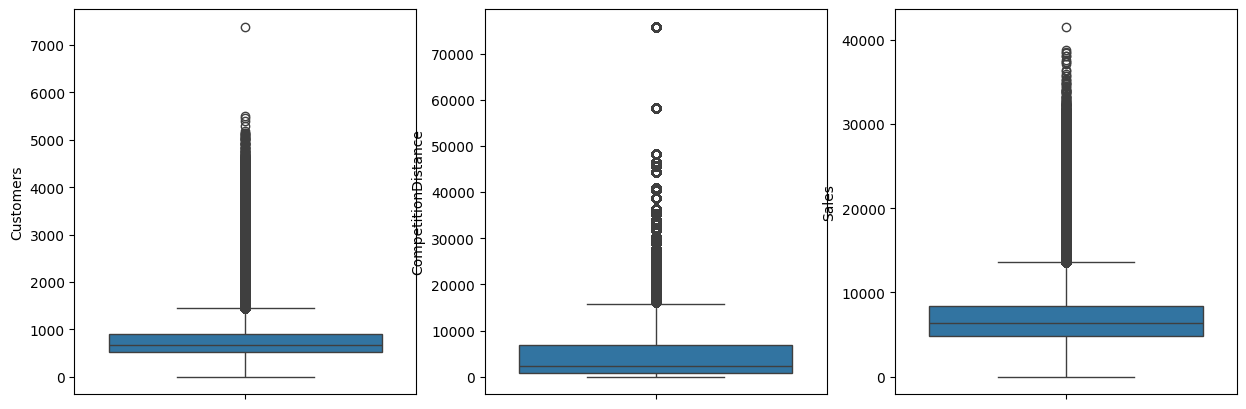

In [27]:
# Plotando Gráficos
fig, ax = plt.subplots(1, 3, figsize=(15,5))
sbn.boxplot(data=df2, y='Customers', ax=ax[0]);
sbn.boxplot(data=df2, y='CompetitionDistance', ax=ax[1]);
sbn.boxplot(data=df2, y='Sales', ax=ax[2]);

Observe que temos a presença de muitos outliers nos nossos dados. Entretanto, precisamos entender que esses outliers não são anomalias, mas sim, características naturais dos dados.
Logo, não é recomendado que nós deletemos eles, entretanto, cogitemos modelos que consigam superar esses outliers.

In [28]:
# Resumo Estatístico Final
df2.select_dtypes(include=['int64', 'float64']).describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
count,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00
mean,558.37,3.52,6959.34,763.27,1.00,0.45,0.19,5457.98,641.75,2010.14,0.50
std,321.92,1.72,3104.46,401.38,0.00,0.50,0.40,7809.44,932.79,4.41,0.50
min,1.00,1.00,0.00,0.00,1.00,0.00,0.00,20.00,1.00,1961.00,0.00
25%,280.00,2.00,4864.00,519.00,1.00,0.00,0.00,710.00,6.00,2008.00,0.00
50%,557.00,3.00,6373.00,676.00,1.00,0.00,0.00,2320.00,10.00,2012.00,0.00
75%,837.00,5.00,8363.00,893.00,1.00,1.00,0.00,6890.00,2013.00,2013.00,1.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,2013.00,2015.00,1.00


Portanto, com os dados consolidados, tratados e limpos, podemos ir para a próxima etapa.

## 3.0 Engenharia de Atributos

O objetivo dessa etapa é conseguir ver a possibilidade de informações que estão 'escondidas' nos dados. Podemos obervar que o nosso dataset é bem limitado, sendo assim, vamos inicialmente construir nossa variável que é as vendas das próximas 6 semanas.

In [61]:
# Cópia dos Dados
df3 = df2.copy()

Após a cópia de uma novo dataset, vamos agregar os dados em semanas de modo a atingir nosso objetivo. Sendo assim, vamos anotar as seguintes ideias:
1. Quantidade Faturada na semana (Variável Alvo)
2. Quantidade de Promoções na semana.
3. Quantidade média de clientes na semana.
4. Quantidade de Promoçoes na semana.
5. Quantidade de Feriados na semana.
6. Quantidade de Férias escolares na semana.
7. Quantidade de Promo2 na semana.

In [62]:
# Ordenando os dados por ordem de loja e ordem de vendas
df3_sorted = df3.sort_values(by=['Store', 'Date'], ascending=True).reset_index(drop=True)

# Extraindo a semana da data
df3_sorted['WeekDate'] = df3_sorted['Date'].apply(lambda x: x.week)
df3_sorted['YearDate'] = df3_sorted['Date'].apply(lambda x: x.year)

# Eliminando a variável Date e variáveis que não fazem sentido para o nosso objetivo
df3_sorted = df3_sorted.drop(columns=['Date', 'DayOfWeek', 'Open'], axis=1)

# Organizando as variáveis
df3_sorted = df3_sorted[['Store', 'WeekDate', 'YearDate', 'Promo',  'Promo2', 
                         'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                         'CompetitionDistance', 'CompetitionOpenSinceMonth', 
                         'CompetitionOpenSinceYear', 'Customers','Sales']].copy()

Para que o nosso ojetivo seja atingido, vamos iniciar a construção de algumas variáveis. A variável StateHoliday representa três feriados, no caso, a = Feriado públicos, b = Páscpa, c = Natal e 0 = Nenhum. Rapidamente, vemos que essa variável carrega três variáveis. Sendo assim, vamos normalizar essas informações por meio de variávei dummies. Veja que não faz sentido carregarmos a variável dummis de nemhum feriado, pois caso as outra variáveis dummies sejam zero, então não temos nenhum feriado.

In [63]:
# Construção das variáveis dummies
df3_sorted = pd.get_dummies(data=df3_sorted, columns=['StateHoliday'], dtype=np.int64)

# Renomeando as variáveis Dummies 
df3_sorted = df3_sorted.rename(columns={'StateHoliday_0': 'NoHoliday', 
                                        'StateHoliday_a': 'PublicHoliday',
                                        'StateHoliday_b': 'EasterHoliday',
                                        'StateHoliday_c': 'ChristmasHoliday'})


df3_sorted = df3_sorted[['Store', 'WeekDate', 'YearDate', 'Promo', 'Promo2', 'NoHoliday', 'PublicHoliday', 'EasterHoliday', 'ChristmasHoliday', 
                         'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
                         'Customers', 'Sales']].drop(columns=['NoHoliday'], axis=1).copy()

# Amostra dos Dados
df3_sorted.head(5)

,Store,WeekDate,YearDate,Promo,Promo2,PublicHoliday,EasterHoliday,ChristmasHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Sales
0,1,1,2013,0,0,0,0,0,1,c,a,1270.00,9.00,2008.00,668,5530
1,1,1,2013,0,0,0,0,0,1,c,a,1270.00,9.00,2008.00,578,4327
2,1,1,2013,0,0,0,0,0,1,c,a,1270.00,9.00,2008.00,619,4486
3,1,1,2013,0,0,0,0,0,1,c,a,1270.00,9.00,2008.00,635,4997
4,1,2,2013,1,0,0,0,0,1,c,a,1270.00,9.00,2008.00,785,7176


Nesse momento, vamos iniciar nossa modelagem de dados e engenharia de atributos.

In [64]:
# Agregação de Soma
df3_aggregate_sum = (df3_sorted[['Store', 'WeekDate', 'YearDate', 'Promo', 'Promo2', 'PublicHoliday', 'EasterHoliday', 'ChristmasHoliday', 'SchoolHoliday', 'Sales']]
                            .groupby(['Store', 'WeekDate', 'YearDate'])
                            .sum(['Promo', 'Promo2', 'PublicHoliday', 'EasterHoliday', 'ChristmasHoliday', 'SchoolHoliday', 'Sales']).reset_index()
                            .sort_values(by=['Store', 'YearDate', 'WeekDate'], ascending=True).reset_index(drop=True))

# Amostra dos dados
df3_aggregate_sum.head(10)

,Store,WeekDate,YearDate,Promo,Promo2,PublicHoliday,EasterHoliday,ChristmasHoliday,SchoolHoliday,Sales
0,1,1,2013,0,0,0,0,0,6,28895
1,1,2,2013,5,0,0,0,0,5,32952
2,1,3,2013,0,0,0,0,0,0,25978
3,1,4,2013,5,0,0,0,0,0,33071
4,1,5,2013,0,0,0,0,0,0,28693
5,1,6,2013,5,0,0,0,0,0,35771
6,1,7,2013,0,0,0,0,0,0,27880
7,1,8,2013,5,0,0,0,0,0,32951
8,1,9,2013,0,0,0,0,0,0,27027
9,1,10,2013,5,0,0,0,0,0,37016


In [65]:
# Agregação de Média
df3_aggregate_mean = (df3_sorted[['Store', 'WeekDate', 'YearDate', 'Customers']].groupby(['Store', 'WeekDate', 'YearDate'])
                                                                                .mean(['Customers']).reset_index()
                                                                                .sort_values(by=['Store', 'YearDate', 'WeekDate'], ascending=True)
                                                                                .reset_index(drop=True))

df3_aggregate_mean['Customers'] = np.round(df3_aggregate_mean['Customers'])

# Amostra dos Dados
df3_aggregate_mean.head(10)

,Store,WeekDate,YearDate,Customers
0,1,1,2013,599.00
1,1,2,2013,653.00
2,1,3,2013,570.00
3,1,4,2013,644.00
4,1,5,2013,594.00
5,1,6,2013,682.00
6,1,7,2013,606.00
7,1,8,2013,647.00
8,1,9,2013,580.00
9,1,10,2013,727.00


In [66]:
# Armazenando as variáveis distintas
df3_cad = df3_sorted[['Store','StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].drop_duplicates()

df3_cad.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
0,1,c,a,1270.00,9.00,2008.00
781,2,a,a,570.00,11.00,2007.00
1565,3,a,a,14130.00,12.00,2006.00
2344,4,c,c,620.00,9.00,2009.00
3128,5,a,a,29910.00,4.00,2015.00
3907,6,a,a,310.00,12.00,2013.00
4687,7,a,c,24000.00,4.00,2013.00
5473,8,a,a,7520.00,10.00,2014.00
6257,9,a,c,2030.00,8.00,2000.00
7036,10,a,a,3160.00,9.00,2009.00


In [67]:
# Construindo o Dataset Final
df3_modelada = (df3_cad.merge(df3_aggregate_sum, how='left', on='Store')
                       .merge(df3_aggregate_mean, how='left', on=['Store', 'WeekDate', 'YearDate'])
                       .drop(columns=['CompetitionOpenSinceMonth'], axis=1))

# Amostra do Resultado
df3_modelada.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,WeekDate,YearDate,Promo,Promo2,PublicHoliday,EasterHoliday,ChristmasHoliday,SchoolHoliday,Sales,Customers
0,1,c,a,1270.00,2008.00,1,2013,0,0,0,0,0,6,28895,599.00
1,1,c,a,1270.00,2008.00,2,2013,5,0,0,0,0,5,32952,653.00
2,1,c,a,1270.00,2008.00,3,2013,0,0,0,0,0,0,25978,570.00
3,1,c,a,1270.00,2008.00,4,2013,5,0,0,0,0,0,33071,644.00
4,1,c,a,1270.00,2008.00,5,2013,0,0,0,0,0,0,28693,594.00


Até aqui, percebemos que a variável abertura do mÊs de competição não está fazendo sentido para nós, dado o nosso objetivo. Logo, vamos eliminar essa variável. Além, a variável de ano de abertura da concorrência não é tão bom. Para o nosso objetivo, faz mais sentido colocar quantos anos de competição desde a abertura da loja concorrente.

In [68]:
# Construindo a variável anos de competição.
df3_modelada['YearCompetition'] = np.int64(df3_modelada['YearDate'].max() - df3_modelada['CompetitionOpenSinceYear'])

# Eliminando a variável
df3_modelada = df3_modelada.drop(columns=['CompetitionOpenSinceYear'], axis=1)

# Organizando o dataset
df3_modelada = df3_modelada[['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'YearCompetition',
                             'WeekDate', 'YearDate', 'Promo', 'Promo2', 
                             'PublicHoliday', 'EasterHoliday', 'ChristmasHoliday', 'SchoolHoliday', 
                             'Customers', 'Sales']].copy()

# Amostra final dos dados
df3_modelada.head(10)

,Store,StoreType,Assortment,CompetitionDistance,YearCompetition,WeekDate,YearDate,Promo,Promo2,PublicHoliday,EasterHoliday,ChristmasHoliday,SchoolHoliday,Customers,Sales
0,1,c,a,1270.00,7,1,2013,0,0,0,0,0,6,599.00,28895
1,1,c,a,1270.00,7,2,2013,5,0,0,0,0,5,653.00,32952
2,1,c,a,1270.00,7,3,2013,0,0,0,0,0,0,570.00,25978
3,1,c,a,1270.00,7,4,2013,5,0,0,0,0,0,644.00,33071
4,1,c,a,1270.00,7,5,2013,0,0,0,0,0,0,594.00,28693
5,1,c,a,1270.00,7,6,2013,5,0,0,0,0,0,682.00,35771
6,1,c,a,1270.00,7,7,2013,0,0,0,0,0,0,606.00,27880
7,1,c,a,1270.00,7,8,2013,5,0,0,0,0,0,647.00,32951
8,1,c,a,1270.00,7,9,2013,0,0,0,0,0,0,580.00,27027
9,1,c,a,1270.00,7,10,2013,5,0,0,0,0,0,727.00,37016


Aqui, finaliazamos a modelagem da nossa base e, a partir daqui, construíremos a nossa variável alvo que, no caso, são as vendas das próximas 6 semanas. 

In [69]:
# Obtendo a quantidade de faturmento da 6 semana
df3_six_weeks = df3_modelada[['Store', 'WeekDate', 'YearDate', 'Sales']].shift(-6).rename(columns={'Store':'ShiftStore','WeekDate':'ShiftWeekDate', 'YearDate':'ShiftYearDate', 'Sales':'ShiftSales'})

# Concatenação dos Dados
df3_modelagem = pd.concat([df3_modelada, df3_six_weeks], axis=1)

# Construção de Flag para eliminar intervalos que não são 6 semanas
df3_modelagem['Flag'] = np.where( (df3_modelagem['Store'] == df3_modelagem['ShiftStore']) & (df3_modelagem['YearDate'] == df3_modelagem['ShiftYearDate']) , df3_modelagem['ShiftWeekDate'] - df3_modelagem['WeekDate'],
                                 np.where( (df3_modelagem['Store'] == df3_modelagem['ShiftStore']) & (df3_modelagem['YearDate'] != df3_modelagem['ShiftYearDate']), df3_modelagem['ShiftWeekDate'] + (52 -df3_modelagem['WeekDate']), -1)
                                )

# Obtendo os dados corretos
df3_modelagem = (df3_modelagem[df3_modelagem['Flag']  == 6].drop(columns=['ShiftStore', 'ShiftWeekDate', 'ShiftYearDate', 'Flag', 'Sales'])
                                                           .rename(columns={'ShiftSales': 'SalesSixthWeek'}))

# Amostra dos Dados
df3_modelagem.sample(10)

,Store,StoreType,Assortment,CompetitionDistance,YearCompetition,WeekDate,YearDate,Promo,Promo2,PublicHoliday,EasterHoliday,ChristmasHoliday,SchoolHoliday,Customers,SalesSixthWeek
131239,1007,c,c,4180.00,3,9,2014,0,0,0,0,0,0,719.00,32448.00
104969,806,d,a,260.00,2,1,2015,0,2,0,0,0,1,459.00,30613.00
102591,788,a,c,1530.00,2,4,2014,5,0,0,0,0,0,1637.00,122043.00
79223,607,a,a,350.00,16,20,2014,0,6,0,0,0,0,325.00,15902.00
2429,19,a,c,3240.00,2,25,2013,5,6,0,0,0,0,602.00,42020.00
38528,297,a,a,2300.00,5,2,2015,4,0,0,0,0,1,831.00,44338.00
129694,995,d,a,6560.00,2,33,2014,0,0,0,0,0,5,679.00,47208.00
55134,423,b,a,1270.00,1,4,2014,5,0,0,0,0,0,1590.00,73216.00
76853,589,a,c,360.00,2,29,2014,5,6,0,0,0,0,581.00,21533.00
113206,869,c,a,230.00,14,20,2013,5,6,0,0,0,0,1018.00,34028.00


Portanto, temos o nosso conjunto de dados modelado e pronto para ir a fase do pré-processamento dos dados.

## 4.0 Treino, Validação e Teste

In [70]:
# Cópia dos Dados
df4=df3_modelagem.copy()
validacao_dados(df4, 'df4')

Validação dos Dados: df4
Quantidade de Linhas: 137299, Quantidade de Colunas: 15.


In [71]:
# Separação do Dataset entre variável alvo e variáveis independentes
X = df4.drop(columns=['Store', 'SalesSixthWeek', 'WeekDate', 'YearDate'], axis=1).reset_index(drop=True)
y = df4['SalesSixthWeek']

# Separação entre Treino, Teste e Validação
X_treino, X_transacional, y_treino, y_transacional = model_selection.train_test_split(X, y, train_size=0.7)
X_teste, X_validacao, y_teste, y_validacao = model_selection.train_test_split(X_transacional, y_transacional, test_size=0.5)


## 5.0 Pré-Processamento dos Dados

Para essa fase, vamos precisar colocar os dados na mesma escala e, além disso, encodar os dados categóricos. Logo, vamos organizar as nossas etapas de execução:
1. StoreType: Aplicaremos one-hot encoding, pois não sabemos se há uma ordem implicita ou não.
2. Assortment: Aplicaremos ordinal encoding, pois existe uma ordem implícita no tipo da loja.
3. No restante das variáveis aplicaremos o Standard Scaler.

In [94]:
# Colunas numéricas a serem transformadas
num_columns = ['CompetitionDistance', 'YearCompetition','Promo', 'Promo2', 'PublicHoliday', 'EasterHoliday', 'ChristmasHoliday', 'SchoolHoliday', 'Customers']

# Instanciando o pipeline para pré-processamento das variáveis numéricas
num_transformer = pipeline.Pipeline(steps=[('scaler', preprocessing.StandardScaler())])

# Colunas categóricas a serem transformadas em variáveis dummies
dummies_columns = ['StoreType']

# Instanciando o pipeline para pré-processamento das variáveis categóricas mque serão dummiesa
dummies_transformer = pipeline.Pipeline(steps=[('dummies', preprocessing.OneHotEncoder(handle_unknown='ignore'))])

# Colunas Categóricas a serem transformadas em ordinal encoding
ordinal_columns = ['Assortment']

# Instanciando o pipeline para pré-processsamento das variávies categóricas que assumiram uma ordem
ordinal_transformer = pipeline.Pipeline(steps=[('ordinal', preprocessing.OrdinalEncoder(categories=[['a', 'b', 'c']], handle_unknown='use_encoded_value', unknown_value=-1))])

Construído todo o pipeline de pré-processamento, vamos montar a execução

In [95]:
pre_processamento = compose.ColumnTransformer(transformers=[('num', num_transformer, num_columns),
                                                            ('dummies', dummies_transformer, dummies_columns),
                                                            ('ordinal', ordinal_transformer, ordinal_columns)])

Validação do Pré-Processamento

In [97]:
pre_processamento.fit(X_treino)

,transformers,"[('num', ...), ('dummies', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


Com o nosso pipeline de pré processamento de dados construídos, vamos agora para a etapa de aprendizado de máquina.

## 6.0 Treinamento dos Modelos